In [1]:
import numpy as np

def hfit(x, y, xsem=None, ysem=None, bootcyc=500, withreplacement=True,
         increments=30, autoweight=True, fitwidth=10.0, sharp=1.0,
         zerothresh=0.01, returnboot=False):
    """
    Version 0.5, written by Niel M. Henriksen
    Purpose: Provide a fit and confidence intervals for scatter data.
             Similar in spirit to the LOESS and LOWESS approaches.
    
    ARGUMENTS
      x               x-axis data values, as numpy array. Should be sorted.
      y               y-axis data values, as numpy array
      xsem            SEM uncertainties for x data (optional)
      ysem            SEM uncertainties for y data (optional)
      bootcyc         number of bootstrap iterations to perform (default: 500)
      withreplacement sample a random set of data points each bootstrap cycle,
                      via sampling with replacement (default: True)
      increments      number of evenly spaced increment points to perform a 
                      fit at (default: 30)
      autoweight      automatically increase fitwidth size when there a no 
                      nearby data points. Data points outside of fitwidth are
                      downweighted (default: True)
      fitwidth        minimum size of window to perform the polynomial fit on,
                      as a percentage of the total x data interval size. A 
                      value of 10 is approximately 10% of the total x
                      interval. (default: 10)
      sharp           the fitting window is does not have hard "edges" but
                      gradually decreases the weight of data points outside of
                      the window. If the sharp value is increased, the 
                      inflection between low weight and high weight points
                      becomes very sharp, thus becoming a hard cutoff
                      (default 1.0)
      zerothresh      if the weighting (between 0 - 1) is less than this
                      threshold, set to zero. Prevents distant points from
                      still influencing the fit (default: 0.05)
      returnboot      if True, returns several debugging arrays (default: False)
      
    RETURNS
      xincs           evenly spaced x axis increments
      yincs           the y value fit for each x axis increment
      yci95           95% CI for the y values
    
    EXAMPLE

    >>> x = np.sort(np.random.uniform(9,11,30))
    >>> y = -10*(x-10)**2 + np.random.normal(0,1.0,len(x))
    >>> ysem = np.random.gamma(1.0,1.0,len(y))
    >>> xincs,yincs,yci95 = hfit(x,y,ysem=ysem,fitwidth=15)
      
    """
        
    def _getweights(vals, targ, totrange, fitwidth, sharp, zerothresh):
        ### Use the formula: 1/(1 + (a(val-targ))**(2**(b)))
        p_fitwidth = 1/(fitwidth*totrange/100.0)
        weights = 1 / ( 1 + ( p_fitwidth * (vals-targ) )**(2**sharp) )
        zero_idxs = weights < zerothresh
        weights[zero_idxs] = 0.0
        return weights
    
    def _autoweight(vals, targ, totrange, fitwidth, sharp, zerothresh):
        ### Get nearby indices to target value, set left/right fitwidth
        left_idx,left_dist,right_idx,right_dist = _maxneighbdist(vals,targ,both=True)
        left_weights = np.empty([0])
        right_weights = np.empty([0])
        left_selfitwidth = 100.0*(1*left_dist/totrange)
        right_selfitwidth = 100.0*(1*right_dist/totrange)
        ### Don't let fitwidths go below overall minimum
        if left_selfitwidth < fitwidth:
            left_selfitwidth = fitwidth
        if right_selfitwidth < fitwidth:
            right_selfitwidth = fitwidth
        ### Do appropriate weighting for left and right sides
        if right_idx - left_idx == 1:
            left_weights = _getweights(vals[0:left_idx+1],targ,totrange,
                                       left_selfitwidth,sharp,zerothresh)
            right_weights = _getweights(vals[right_idx:],targ,totrange,
                                        right_selfitwidth,sharp,zerothresh)
        elif left_idx < 0 or right_idx >= len(vals):
            left_weights = _getweights(vals[0:],targ,totrange,
                                       right_selfitwidth,sharp,zerothresh)
        else:
            left_weights = _getweights(vals[0:right_idx],targ,totrange,
                                       left_selfitwidth,sharp,zerothresh)
            right_weights = _getweights(vals[right_idx:],targ,totrange,
                                        right_selfitwidth,sharp,zerothresh)
        return np.concatenate((left_weights,right_weights))

    def _normalsample(vals,sems,idxs=None):
        samples = np.zeros([len(vals)])
        if idxs is None:
            idxs = range(len(vals))
        for i,idx in enumerate(idxs):
            samples[i] = np.random.normal(vals[idx],sems[idx])
        return samples
    
    def _maxneighbdist(vals,targ,both=False):
        ### Get the nearby indices
        left_idx = np.searchsorted(vals,targ,side='left')-1
        right_idx = np.searchsorted(vals,targ,side='right')
        ### If targ value is right on top of a point, get next nearest idx
        if 0 <= left_idx < len(vals) and vals[left_idx] == targ:
            left_idx -= 1
        if 0 <= right_idx < len(vals) and vals[right_idx] == targ:
            right_idx += 1
        ### Find the distances to the nearby idxs
        left_dist = 0.0
        if left_idx >= 0:
            left_dist = targ - vals[left_idx]
        right_dist = 0.0
        if right_idx < len(vals):
            right_dist = vals[right_idx] - targ
        ### Return
        if both:
            return left_idx,left_dist,right_idx,right_dist
        elif left_dist >= right_dist:
            return left_dist
        else:
            return right_dist
    
    ### Setup some arrays and variables
    xincs = np.linspace(np.min(x), np.max(x), increments)
    yincboot = np.zeros([len(xincs),bootcyc], np.float64)
    if returnboot:
        pboot = np.zeros([len(xincs),bootcyc,3], np.float64)
        weightboot = np.zeros([len(xincs),bootcyc,len(x)], np.float64)
        tmpxboot = np.zeros([bootcyc,len(x)], np.float64)
        tmpyboot = np.zeros([bootcyc,len(y)], np.float64)
    totrange = x[-1]-x[0]
    
    ### Run bootstrap
    for b in range(bootcyc):
        if bootcyc > 1 and withreplacement: ### Either Random Sampling With Replacement ...
            unique_points = 0
            while unique_points < 4:  #If we have 3 or less points, bad news bears
                bootidxs = np.sort(np.random.randint(len(x), size=len(x)))
                unique_points = len(set(bootidxs))
            if xsem is not None: # If x uncertainties are available, bootstrap off of those too.
                tmpx = _normalsample(x,xsem,idxs=bootidxs)
            else:
                tmpx = np.asarray(x[bootidxs])
            if ysem is not None: # If y uncertainties are available, bootstrap off of those too.
                tmpy = _normalsample(y,ysem,idxs=bootidxs)
            else:
                tmpy = np.asarray(y[bootidxs])
        else: ### ... Or just use the raw data and sample off uncertainties, if they exist
            if xsem is not None:
                tmpx = _normalsample(x,xsem)
            else:
                tmpx = np.asarray(x)
            if ysem is not None:
                tmpy = _normalsample(y,ysem)
            else:
                tmpy = np.asarray(y)
            
        if returnboot:
                tmpxboot[b] = tmpx
                tmpyboot[b] = tmpy
                
        ### For each x increment, compute a fit
        for i,xinc in enumerate(xincs):
            if autoweight:
                weights = _autoweight(tmpx, xinc, totrange, fitwidth, sharp, zerothresh)
            else:
                weights = _getweights(tmpx, xinc, totrange, fitwidth, sharp, zerothresh)
            p = np.polyfit(tmpx, tmpy, 2, w=weights)
            if returnboot:
                pboot[i,b] = p
                weightboot[i,b] = weights
            yincboot[i,b] = p[0]*(xinc**2) + p[1]*(xinc) + p[2]
            
    ### Compute means and 95% CI
    yincs = xincs*0.0
    yci95 = xincs*0.0
    for i,xinc in enumerate(xincs):
        yincs[i] = np.mean(yincboot[i])
        yci95[i] = 1.96*np.std(yincboot[i])
    ### Return
    if returnboot:
        return xincs,yincs,yci95,yincboot,pboot,weightboot,tmpxboot,tmpyboot
    else:
        return xincs,yincs,yci95



In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep

<IPython.core.display.Javascript object>


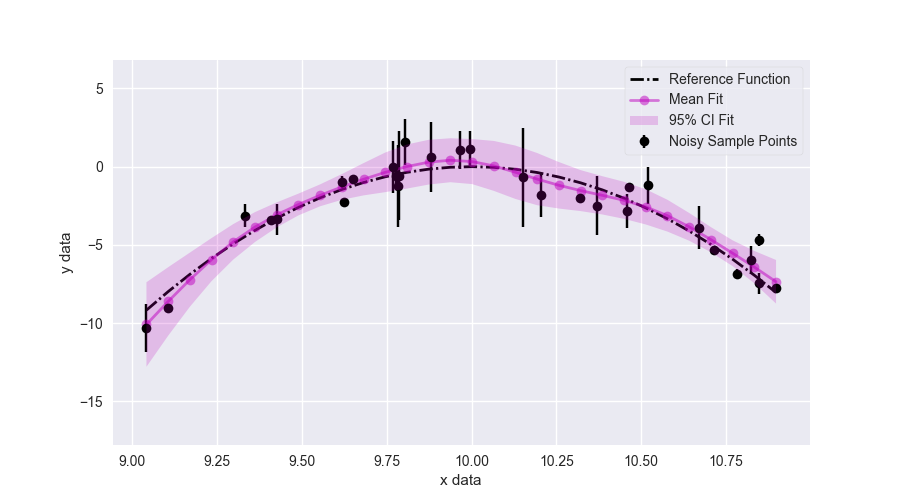

In [3]:
######################################
### Example 1
### Fit some quadratic shaped data

### Generate test case
x = np.sort(np.random.uniform(9,11,30))
y = -10*(x-10)**2 + np.random.normal(0,1.0,len(x))
ysem = np.random.gamma(1.0,1.0,len(y))
xincs,yincs,yci95 = hfit(x,y,ysem=ysem,fitwidth=15)

### Plot results
fig,axs = plt.subplots(figsize=(9,5))
axs.set_xlabel('x data')
axs.set_ylabel('y data')
axs.errorbar(x,y,yerr=ysem,fmt='ko', label='Noisy Sample Points')
axs.plot(xincs,-10*(xincs-10)**2,'k-.', lw=2, label='Reference Function')
axs.plot(xincs, yincs, 'm-o', lw=2, alpha=0.5, label='Mean Fit')
ypci = yincs + yci95
ynci = yincs - yci95
axs.fill_between(xincs, ynci, ypci, where=ypci >= ynci, facecolor='m',
                 alpha=0.2, interpolate=False, zorder=10, label='95% CI Fit')
axs.axis([np.min(x)-0.1,np.max(x)+0.1,np.min(ynci)-5,np.max(ypci)+5])
axs.legend(loc='upper right', frameon=True)
fig.canvas.draw()

<IPython.core.display.Javascript object>


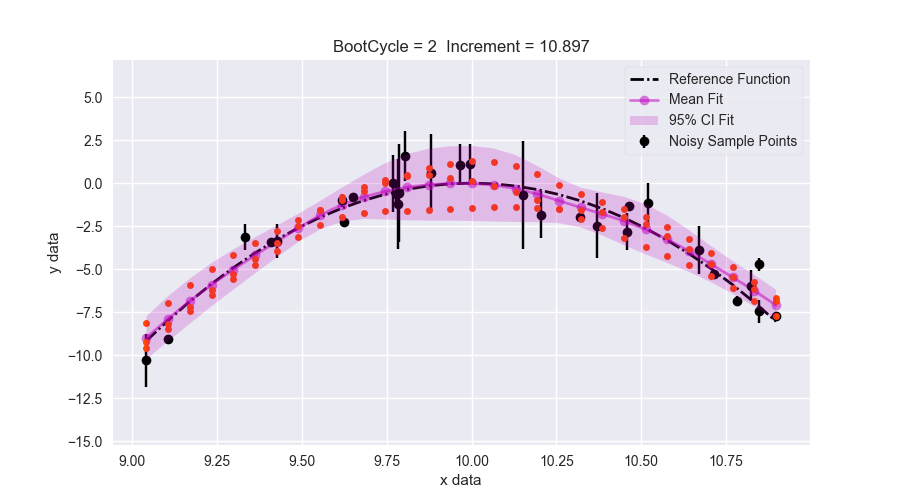

In [4]:
######################################
### Example 2
### Demonstrate the algorithm

### Run hfit
xincs,yincs,yci95,yincboot,\
pboot,weightboot,tmpxboot,tmpyboot = hfit(x,y,ysem=ysem,bootcyc=3,fitwidth=15,returnboot=True)
ypci = yincs + yci95
ynci = yincs - yci95

### Plot Orig Data
fig,axs = plt.subplots(figsize=(9,5))
axs.set_xlabel('x data')
axs.set_ylabel('y data')
axs.errorbar(x,y,yerr=ysem,fmt='ko', label='Noisy Sample Points')
axs.plot(xincs,-10*(xincs-10)**2,'k-.', lw=2, label='Reference Function')

for b in range(len(yincboot[0])):
    plts = []
    for i,xinc in enumerate(xincs):
        axs.plot(xinc,yincboot[i,b],'o', color='orangered', markersize=5, alpha=1, zorder=5)
        p = pboot[i,b]
        plts.append( axs.plot(xincs,p[0]*(xincs**2) + p[1]*(xincs) + p[2],'g-',lw=1, alpha=0.2)[0] )
        title = "BootCycle = {:.0f}  Increment = {:.3f}".format(b,xinc)
        axs.set_title(title)
        fig.canvas.draw()
        sleep(0.05)
        bootpoints = []
        for j in range(len(tmpxboot[b])):
            bootpoints.append( axs.plot(tmpxboot[b,j],tmpyboot[b,j], 'o', markersize=10, markeredgewidth=3,
                                        markeredgecolor='g', markerfacecolor='None', alpha=weightboot[i,b,j])[0] )
        fig.canvas.draw()
        sleep(0.20)
        for j in range(len(bootpoints)):
            bootpoints[j].remove()
        fig.canvas.draw()
        
    
    for i in range(len(plts)):
        plts[i].remove()
    fig.canvas.draw()
            
### Plot Fit Data
axs.plot(xincs, yincs, 'm-o', lw=2, alpha=0.5, label='Mean Fit')
ypci = yincs + yci95
ynci = yincs - yci95
axs.fill_between(xincs, ynci, ypci, where=ypci >= ynci, facecolor='m',
                 alpha=0.2, interpolate=False, zorder=10, label='95% CI Fit')
axs.axis([np.min(x)-0.1,np.max(x)+0.1,np.min(ynci)-5,np.max(ypci)+5])
axs.legend(loc='upper right', frameon=True)
fig.canvas.draw()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarnin

<IPython.core.display.Javascript object>


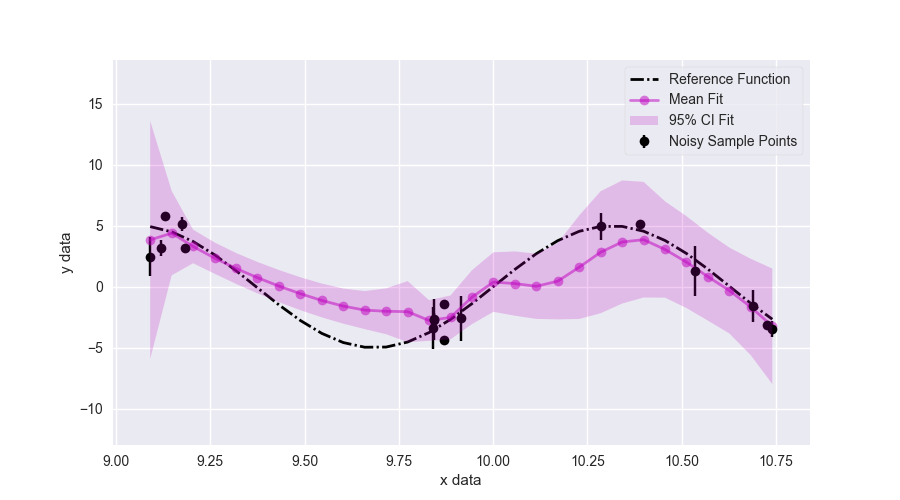

In [5]:
######################################
### Example 3
### When things go wrong.
### Situation: fitwidth too small, gaps in data
### Result: weird shape fit, huge CIs, polyfit warnings

### Generate some scatter with duplicates (trickier)
x = np.sort(np.random.uniform(9,11,30))
dups = []
for i,val in enumerate(x):
    if np.random.rand(1) < 0.2:
        dups.append(x[i])
x = np.sort(np.concatenate((x,np.asarray(dups))))

### Cut out some gaps
new_idxs = list(range(len(x)))
new_idxs = new_idxs[0:5] + new_idxs[12:18] + new_idxs[24:30]
x2 = x[new_idxs]
y2 = 5*np.sin(5*(x2-10)) + np.random.normal(0,1.0,len(x2))
y2sem = np.random.gamma(1.0,1.0,len(y2))

### Fit
xincs,yincs,yci95 = hfit(x2,y2,ysem=y2sem,fitwidth=5)

### Plot results
fig,axs = plt.subplots(figsize=(9,5))
axs.set_xlabel('x data')
axs.set_ylabel('y data')
axs.errorbar(x2,y2,yerr=y2sem,fmt='ko', label='Noisy Sample Points')
axs.plot(xincs,5*np.sin(5*(xincs-10)),'k-.', lw=2, label='Reference Function')
axs.plot(xincs, yincs, 'm-o', lw=2, alpha=0.5, label='Mean Fit')
ypci = yincs + yci95
ynci = yincs - yci95
axs.fill_between(xincs, ynci, ypci, where=ypci >= ynci, facecolor='m',
                 alpha=0.2, interpolate=False, zorder=10, label='95% CI Fit')
axs.axis([np.min(x2)-0.1,np.max(x2)+0.1,np.min(ynci)-5,np.max(ypci)+5])
axs.legend(loc='upper right', frameon=True)
fig.canvas.draw()
